### Installing and importing the required modules

In [ ]:
import os
import sys
import torch
import dotenv
import warnings
import pandas as pd
import seaborn as sns
from pathlib import Path
from trl import SFTTrainer
from datasets import Dataset
import matplotlib.pyplot as plt
from huggingface_hub import login
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
from transformers import TrainingArguments
from unsloth.chat_templates import get_chat_template

# Add the parent directory to the system path
sys.path.append(str(Path().resolve().parent))

# Import local dependencies
from src.utils import get_device, set_seed

In [ ]:
# Load environment variables
dotenv.load_dotenv(dotenv_path=".env", override=True)

### Setting up the environment

In [ ]:
# Extract the hugging face token from the user data
HF_TOKEN = os.getenv('HF_TOKEN')

# Check if the HF token has been provided
if not HF_TOKEN:
  # Raise an exception if the HF token was not provided
  raise Exception("Token is not set. Please save the token first.")

# Authenticate with hugging face
login(HF_TOKEN)

# Login successful
print("Successfully logged in to Hugging Face!")

In [ ]:
# Disable warnings
warnings.filterwarnings("ignore")

### Constants, hyperparameters and model configurations

In [18]:
# Set the plot style
plt.style.use('ggplot')

In [ ]:
seed = 42 # Seed for reproducibility
test_size = 0.2 # Train-test split percentage
max_seq_length = 512 # Maximum sequence length
model_id = "unsloth/Qwen3-1.7B-unsloth-bnb-4bit" # The model ID
dataset_path = "hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json" # The path to the dataset
model_path = Path().resolve().parent.parent / "saved_models" / "mental_health_chatbot" # Path to save the trained model to

In [ ]:
# Set the seed for reproducibility
set_seed(seed)

In [ ]:
# Get the device available on the system
device = get_device()
use_cuda = torch.cuda.is_available() and "cuda" in str(device).lower()

# Print the detected device
print(f"Detected device: {device}")

### Data loading

In [ ]:
# Load the dataset into a pandas DataFrame
data = pd.read_json(dataset_path, lines=True)

# Remove rows with missing values in the "Context" or "Response" columns
data = data.dropna(subset=["Context","Response"])
data["Context_length"] = data["Context"].astype(str).str.len()
data["Response_length"] = data["Response"].astype(str).str.len()

In [20]:
# Display the first 5 rows of the dataset
data.head()

,Context,Response,Context_length,Response_length
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",328,961
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",328,2082
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,328,299
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,328,844
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,328,337


### Exploratory data analysis

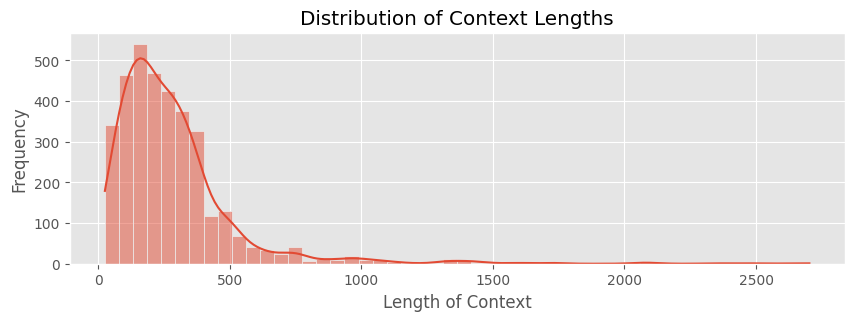

In [19]:
# Length of the words in each context
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data=data, x='Context_length', bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Length of the words in each response
data['Response_length'] = data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data=data, x='Response_length', bins=50, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

### Building the model

In [ ]:
# Determine whether to load the model in 4-bit or float32
load_in_4bit = bool(torch.cuda.is_available())
dtype = None if load_in_4bit else "float32"

# Loading the model and the tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,
    max_seq_length = max_seq_length,
    load_in_4bit = True,
    dtype = dtype
)

# Set the parameters for padding
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

In [ ]:
# Loading the model and applying LoRA (Low-rank adaptation) to the model
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0.1,
    target_modules = [ 
        "q_proj",
        "k_proj", 
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    use_rslora = True,
    use_gradient_checkpointing = "unsloth",
    random_state = seed,
    loftq_config = None
)

In [ ]:
# Print trainable parameters
model.print_trainable_parameters()

### Data preparation

In [ ]:
# Get the chat template
chat_template = get_chat_template(model_name=model_id, tokenizer=tokenizer)

# Function to format the prompts
def formatting_prompt(examples: dict) -> dict:
	# Extract contexts and responses
	contexts = examples["Context"]
	responses = examples["Response"]

	# Initialize list to hold formatted texts
	texts = []

	# Iterate through contexts and responses
	for context, response in zip(contexts, responses):
		# Initialize the prompt using the chat template
		messages = [
			{"role": "system", "content": "You are a mental health assistant."},
			{"role": "user", "content": (
				"Analyze the provided text from a mental health perspective. "
				"Identify indicators of emotional distress, coping mechanisms, or well-being. "
				"Highlight any concerns or positive aspects and explain briefly.\n\n"
				f"### Input:\n{context}"
			)},
			{"role": "assistant", "content": response},
		]
  
        # Apply the chat template to format the messages
		text = chat_template.apply_chat_template(
			messages,
			add_generation_prompt = False,
			tokenize = False
		)

		# Ensure the text ends with the eos_token
		if not text.endswith(tokenizer.eos_token):
			text += tokenizer.eos_token
   
		# Append the formatted text to the list
		texts.append(text)
		
	# Return the formatted texts
	return {"text": texts}

In [ ]:
# Formatting the training data
dataset = Dataset.from_pandas(data)
dataset = dataset.map(formatting_prompt, batched=True)

# Train-test split
train_dataset, test_dataset = dataset.train_test_split(test_size=test_size, seed=seed).values()

### Trainig the model

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
	learning_rate = 3e-4,
	output_dir = "./checkpoints/mental_health_chatbot",
	eval_strategy = "epoch",
    save_strategy = "epoch",
	logging_dir = "./logs",
	logging_strategy = "epoch",
	lr_scheduler_type = "linear",
	per_device_train_batch_size = 8,
	gradient_accumulation_steps = 8,
	num_train_epochs = 10,
	bf16 = is_bfloat16_supported(),
	logging_steps = 1,
	optim = "adamw_8bit",
	weight_decay = 0.01,
	warmup_steps = 10,
	report_to = "none",
	seed = seed
)

In [ ]:
# Instantiate the trainer to train the model
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True,
    args = training_args
)

In [ ]:
# Trainin the model
trainer.train()

### Save the model

In [ ]:
# Merge LoRA weights into the base model
merged = FastLanguageModel.merge_and_unload(model)

# Save the merged model and tokenizer
merged.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

### Load the fine-tuned model

In [ ]:
# Clear GPU cache
if torch.cuda.is_available():
	torch.cuda.empty_cache()

In [ ]:
# Loading the fine-tuned model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_path,
    max_seq_length = max_seq_length,
    load_in_4bit = True
)

# Get the chat template
chat_template = get_chat_template(model_name=model_id, tokenizer=tokenizer)

In [ ]:
# Set the model to evaluation mode
model.eval();

### Inference

In [ ]:
# Example context for analysis
context = (
	"I've been feeling really overwhelmed lately with everything going on in my life. "
	"Work has been stressful, and I barely have time to relax. "
	"Sometimes I just feel like I'm drowning in responsibilities and can't catch a break. "
	"I try to stay positive, but it's hard when it feels like there's no end in sight."
)

# Initialize the prompt using the chat template
messages = [
	{"role": "system", "content": "You are a mental health assistant."},
	{"role": "user", "content": (
		"Analyze the provided text from a mental health perspective. "
		"Identify indicators of emotional distress, coping mechanisms, or well-being. "
		"Highlight any concerns or positive aspects and explain briefly.\n\n"
		f"### Input:\n{context}"
	)}
]

# Apply the chat template to format the messages
text = chat_template.apply_chat_template(
	messages,
	add_generation_prompt = True,
	tokenize = False
)

# Tokenize the formatted prompt
inputs = tokenizer(
    text,
    truncation = True,
    padding = "longest",
    return_tensors = "pt"
).to(device)

In [ ]:
# Disable gradient calculation
with torch.no_grad():
    # Generate the responses
    outputs = model.generate(
        **inputs,
        max_new_tokens = 128,
        eos_token_id = tokenizer.eos_token_id,
        pad_token_id = tokenizer.pad_token_id
    )

In [ ]:
# Decode the generated response
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the generated response
print("Generated Response:")
print(response)